NANOPLATELET REFINEMENT VIA MULTILAYER DIFFRACTION
-----------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------
INITIALIZATION. 

Always run this section as a first step to load libraries and modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from MD_Core import Mult_Diff

-----------------------------------------------------------------------------------------------------------
INPUT, DATA VISUALIZATION AND LPA CORRECTION

This section takes the experimental data as the input, and applies the Lorentz-Polarization-Absorption Correction (LPA) to prepare the fit. 

Here the user must define some parameters related to the instrumental configuration (X-ray wavelength; Monochromator/Goebel mirror Bragg angle) and to the sample (Absorption factor), as well as the number of nanoplatelets considered for the simulation. 

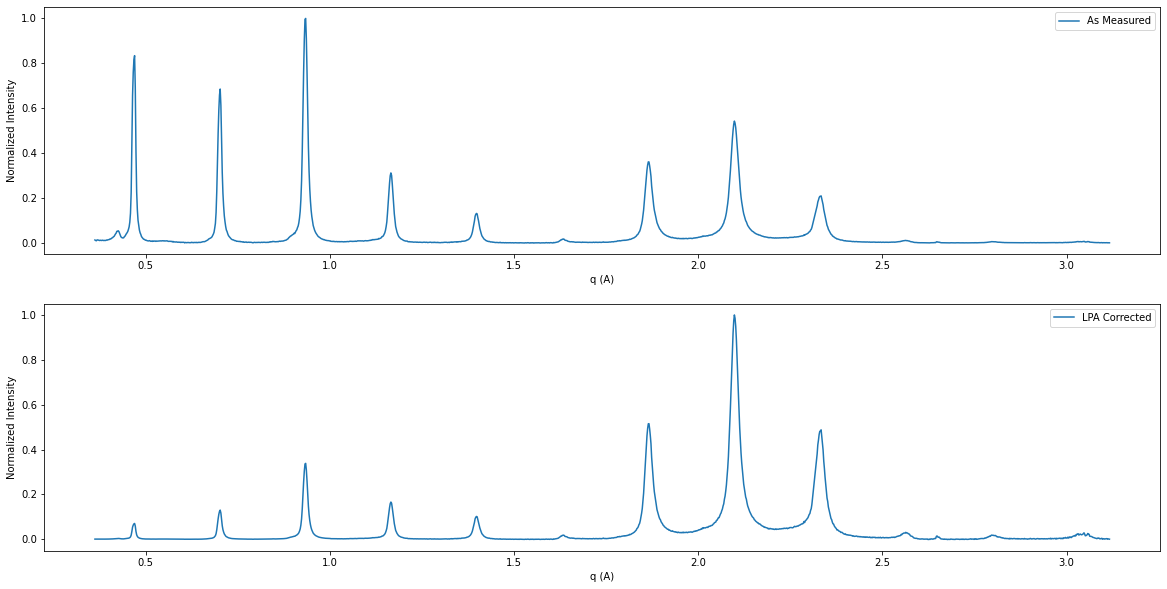

In [2]:
filename = '2ML_Cs-Pb-Br_nanoplatelets_octylamine.csv'   # Load the experimental data file
experiment = Mult_Diff(filename) 

# DEFINE INSTRUMENTAL AND SAMPLE PARAMETERS
experiment.wavelength = 1.54187               # Load the experimental data file
experiment.mirror_angle = 1                   # Monochromator/Goebel mirror Bragg angle in degrees
experiment.ABS = 0.00001                      # Absorption factor = Absorption coefficient x Film thickness. Do not set = 0
experiment.C = 20                             # Number of stacked platelets considered in the simulation. 

#_NO CHANGES BELOW THIS POINT__________________________________________________________________________________________________________________

experiment.correct(experiment.q,experiment.I)
fig,ax = plt.subplots(2,1,figsize = (20,10),sharey = False)
ax[0].plot(experiment.q,experiment.I, label = 'As Measured'); ax[0].set_xlabel('q (A)'); ax[0].legend(); ax[0].set_ylabel('Normalized Intensity')
ax[1].plot(experiment.q,experiment.I_corr, label = 'LPA Corrected'); ax[1].set_xlabel('q (A)'); ax[1].legend(); ax[1].set_ylabel('Normalized Intensity')
plt.show()

-----------------------------------------------------------------------------------------------------------
PRELIMINARY NANOPLATELET STRUCTURE FACTOR SIMULATION

This section allows the user to input a tentative crystal structure for the nanoplatelet, in order to compare it qualitatively with the experimental data. It is useful to identify a suitable initial guess, for example to identify the correct material or thickness of the nanoplatelets. 

The user must first define which elements are found in the sample. If the element is not yet included in the MD_core.py file the program will crash. However, it is possible to add elements by editing the MD_core.py file by adding element-specific constants found here: https://bit.ly/3m23uBU. Use this format to input a new element in the MD_core.py file:

ion_const['Element Symbol'] = [constant 1, constant 2, constant 3, constant 4, constant 5, constant 6, constant 7, constant 8, constant 9]

The user must then input the monodimensional representation of the nanoplatelet crystal structure (experiment.structure_input). Each row in the experiment.structure_input matrix represents one atomic layer. The first column (0) is the fractionary z coordinate of the atomic layer. Odd columns (1,3,5...) contain the symbol of the element found in the atomic layer. No-element is indicated with " ". Even columns (2,4,6...) contain the fractional occupancy of that element in the layer. The fractional coordinates of each atomic layer are transformed into absoulte coordinates by multiplying for a reference length in Angstrom (d_test). This value is in principle arbitrary, however it is convenient to chose a physically meaningful length that is significant for the examined crystal structure (in this example, the vertical Pb-Pb distance).

The output of this section shows the monodimensional representation of the nanoplatelet crystal structure and resulting computed structure factor. 

,0,1,2,3,4
8,0,N,1,Br-,1
7,0.5,,0,Br-,1
6,0.5,Pb2+,1,,0
5,0.5,,0,Br-,1
4,1,Cs+,1,Br-,1
3,1.5,,0,Br-,1
2,1.5,Pb2+,1,,0
1,1.5,,0,Br-,1
0,2,N,1,Br-,1


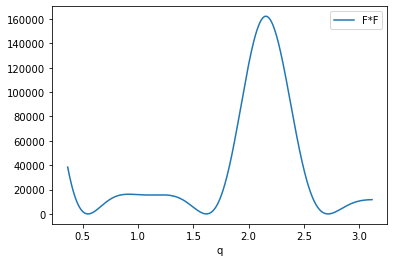

In [3]:
experiment.elements = ["Br-","N","Cs+","Pb2+","C"]  # Define here the elements in the sample. Always include Carbon ("C")

d_test = 5.8
experiment.structure_input = [
                        [2,  "N",   1,"Br-",1],
                        [1.5," ",0,"Br-",1],
                        [1.5,"Pb2+",1," ",0],
                        [1.5," ",0,"Br-",1],
                        [1,  "Cs+", 1,"Br-",1],
                        [0.5," ",0,"Br-",1],
                        [0.5,"Pb2+",1," ",0],
                        [0.5," ",0,"Br-",1],
                        [0,  "N",   1,"Br-",1],
                       ]

#_NO CHANGES BELOW THIS POINT__________________________________________________________________________________________________________________
         
representation = experiment.crystal_generator(experiment.structure_input)
representation = representation.T.iloc[::-1]
representation.rename(columns ={0: "z-coordinate"})
display(representation)
experiment.FF_simulator(d_test)
experiment.F.plot("q","F*F")

-----------------------------------------------------------------------------------------------------------
PRELIMINARY DIFFRACTION PATTERN SIMULATION

This section simulates the diffraction pattern based on the crystal structure input above and on a set of specified parameters. This allows the user to quickly compare the simulation with the experimental pattern, and provide a good starting guess of the parameters values to the fit routine. The input parameters are:
- d = reference length for the fractional coordinates in Å (the same as d_test above)
- L = interparticle spacing in Å
- sigmaL = stacking disorder parameter (i.e. standard deviation of L) in Å
- qzero = shift applied to the pattern in q scale to correct misalignments, in $Å^{-1}$
- inst_b = instrumental contribution to the broadening of diffraction features, described as the standard deviation of the gaussian instrumental response in $Å^{-1}$
- fit_range = range of the diffractogram included in the fit in $Å^{-1}$. The fit range specified here is used all through the rest of the code.

(0.36260707299999995, 2.9987912889999997)

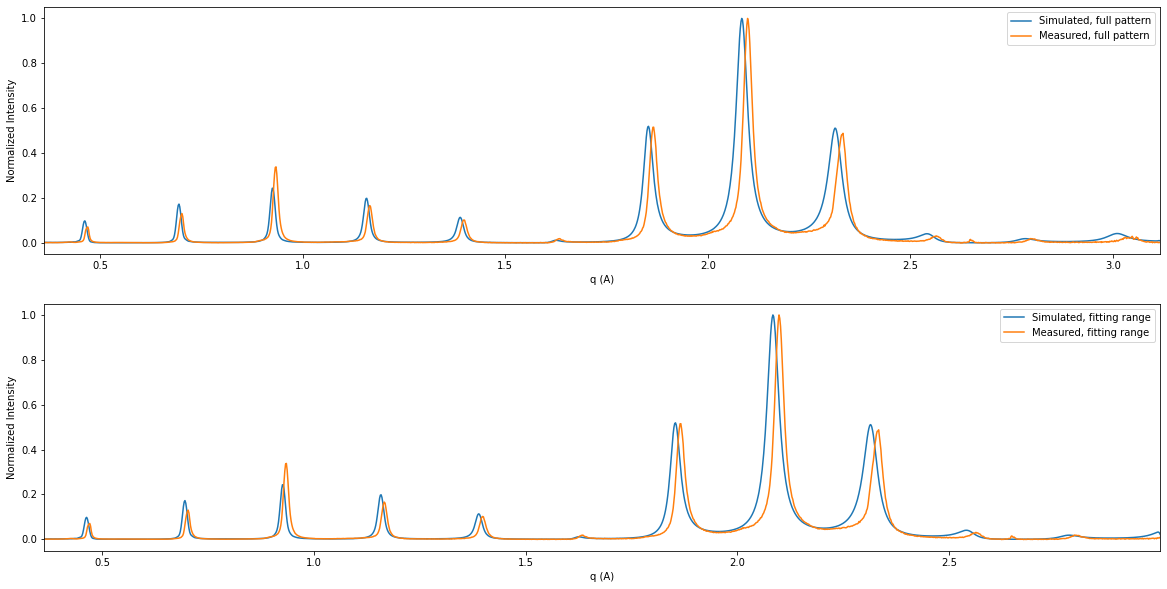

In [4]:
#                [   d       L     sigmaL    qzero  inst_b]
sim_parameters = [5.9325, 15.2675, 0.3000,  0.0000, 0.0030]  
fit_range = [0,3] 

#_NO CHANGES BELOW THIS POINT__________________________________________________________________________________________________________________

experiment.q_range = experiment.q.copy()
experiment.ff_range = experiment.ff
simulated = experiment.simulate_low(sim_parameters)
experiment.correct(experiment.q,experiment.I)

fig_1,ax = plt.subplots(2,1,figsize = (20,10),sharey = False,sharex = False);
ax[0].plot(experiment.q,experiment.I_sim,label = 'Simulated, full pattern');ax[0].plot(experiment.q,experiment.I_corr, label = 'Measured, full pattern') 
ax[0].set_xlabel('q (A)');ax[0].legend();ax[0].set_ylabel('Normalized Intensity');ax[0].set_xlim(min(experiment.q),max(experiment.q))

experiment.data_range = experiment.data[(experiment.data.iloc[:,0].values>fit_range[0]) & (experiment.data.iloc[:,0].values<fit_range[1])]
experiment.q_range = experiment.data_range.values[:,0] ; experiment.I_range = experiment.data_range.values[:,1]
experiment.range_ff = experiment.ff[(experiment.ff.iloc[:,0]>fit_range[0]) & (experiment.ff.iloc[:,0]<fit_range[1])]
simulated = experiment.simulate_low(sim_parameters)
experiment.correct(experiment.q_range,experiment.I_range)

ax[1].plot(experiment.q_range,experiment.I_sim,label = 'Simulated, fitting range');ax[1].plot(experiment.q_range,experiment.I_corr, label = 'Measured, fitting range') 
ax[1].set_xlabel('q (A)');ax[1].legend();ax[1].set_ylabel('Normalized Intensity');ax[1].set_xlim(min(experiment.q_range),max(experiment.q_range))

-----------------------------------------------------------------------------------------------------------
PRELIMINARY DIFFRACTION PATTERN FIT

This section performs a preliminary fit of the experimental pattern, optimizing the input parameters from the section above. The aim of this section is to check how well the starting guess on the nanoplatelet structure matches with the experimental pattern, and provide a good set of starting parameters for the full refinemend that will be performed in the next sections. 

The up_bound and low_bound vectors represent the boundaries within which each parameter is refined. 

The output plot shows the experimental pattern, the best fit of the simulation, and the residual (measured-simulated) curve. The output also includes the best fit values for each refined parameter, together with a set of three figures of merit (S, Rp, Rpw) that can help the user evaluating the goodness of fit. 

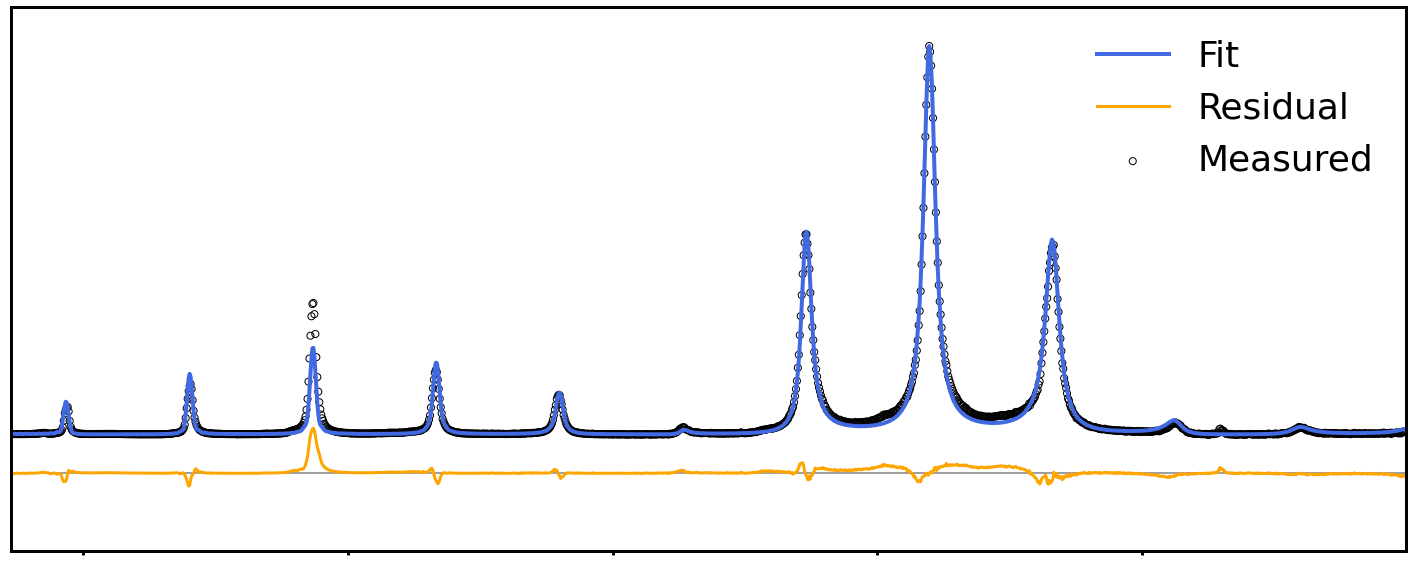

Fit Parameters: [  d         L    sigmaL    qzero   HWHM ]
Fit Parameters: [5.9059, 15.1564, 0.2563, -0.0019, 0.0020]


S:      0.035
Rp:     0.126
Rwp:    0.055


In [5]:
#                [   d       L     sigmaL    qzero   HWHM]
up_bound =       [6.1000, 20.0000, 2.0000,  0.0100, 0.100]
starting_guess = [5.9325, 15.2675, 0.3000,  0.0000, 0.003]
low_bound =      [5.8000, 10.0000, 0.0000, -0.0100, 0.000]

#_NO CHANGES BELOW THIS POINT__________________________________________________________________________________________________________________

bounds = (low_bound, up_bound)
experiment.I_corr = experiment.correct(experiment.q_range,experiment.I_range)
fits = experiment.fit_low(x0 = starting_guess, bounds = bounds)

plt.rcParams["axes.linewidth"] = 3; fig,ax = plt.subplots(1,1,figsize = (25,10),sharey = True)
plt.axhline(y=-0.1, color='grey', linestyle='-')
ax.scatter(experiment.q_range,experiment.I_corr,facecolors = 'none', edgecolor = 'black',linewidth = 1,s = 50 ,label = 'Measured')
ax.plot(experiment.q_range,experiment.I_sim,label = 'Fit', color = 'royalblue', linewidth = 4)
ax.plot(experiment.q_range, experiment.I_corr - experiment.I_sim - 0.1 ,label = 'Residual', color = 'orange', linewidth = 3)
ax.legend(fontsize = 36, frameon = False); plt.ylim(-0.3, 1.1); ax.set_xlim(min(experiment.q_range),max(experiment.q_range))
ax.tick_params(axis = 'both', which = 'major', width = 3, labelsize = 0)
ax.set_yticks([]); plt.show(); plt.rcParams["axes.linewidth"] = 1

print('Fit Parameters: [  d         L    sigmaL    qzero   HWHM ]')
print (('Fit Parameters: ' + str(["{:.4f}".format(x) for x in experiment.x0])).replace('\'', '')); print()

S = np.sum(experiment.I_corr * (experiment.I_corr - experiment.I_sim)**2)
Rp = np.sum(abs(experiment.I_corr - experiment.I_sim))/np.sum(experiment.I_corr)
Rwp = (np.sum(experiment.I_corr*(experiment.I_corr - experiment.I_sim)**2)/(np.sum(experiment.I_corr**3)))**0.5

print()
print ('S:      ' + str("{:.3f}".format(S)))
print ('Rp:     ' + str("{:.3f}".format(Rp)))
print ('Rwp:    ' + str("{:.3f}".format(Rwp)))

-----------------------------------------------------------------------------------------------------------
CURRENT STRUCTURAL MODEL

This section displays the structural model input previously, as a handy reference to have while editing the next section.

In [6]:
display(representation)

,0,1,2,3,4
8,0,N,1,Br-,1
7,0.5,,0,Br-,1
6,0.5,Pb2+,1,,0
5,0.5,,0,Br-,1
4,1,Cs+,1,Br-,1
3,1.5,,0,Br-,1
2,1.5,Pb2+,1,,0
1,1.5,,0,Br-,1
0,2,N,1,Br-,1


-----------------------------------------------------------------------------------------------------------
SET STRUCTURAL CONSTRAINTS

In this section the structure of the nanoplatelet is prepared for the refinement by representing it in terms of independent variables (v1, v2, v3, v4), and defining the mathematical constraints between related parameters. 

It is possible to use less than 4 variables by simply not using them in the description of the structure. Using more than 4 variables is possible as well, but requires to edit the MD_Core.py file. 

In [7]:
def relations(self,structure,v1,v2,v3,v4):

    # structure[row][column] = some function of (v1,v2,v3,v4)   Use this template to specify how each structural parameter depends on v1,v2,v3,v4
    
    # Surface occupancy fraction
    structure[0][2] = v1
    structure[0][4] = v1
    structure[8][2] = v1
    structure[8][4] = v1
    
    # CsBr atomic layer occupancy
    structure[4][2] = v2
    structure[4][4] = v2
    
    # Tilt of the Pb-Br bonds in the PbBr2 layer
    structure[1][0] = 1.5-v3
    structure[2][0] = 1.5
    structure[3][0] = 1.5+v3
    structure[5][0] = 0.5-v3
    structure[6][0] = 0.5
    structure[7][0] = 0.5+v3
    
    return structure

setattr(Mult_Diff,"relations",relations)

-----------------------------------------------------------------------------------------------------------
ADVANCED DIFFRACTION PATTERN FIT

This section performs the fit of the experimental pattern optimizing all the input parameters, includint v1,v2,v3,v4. The parameter C_dens describes the density of the interplatelet spacing in terms of Carbon atoms/Å*unit cell.  In this example C_dens was fixed to a value estimated in advance. By changing experiment.add_var (from 0 to 4) it is possible to decide how many of the v1,v2,v3,v4 parameters will be refined. Non-refined parameters are kept fixed to the valued specified in the starting_guess vector. The order of refined parameters is always v1→v2→v3→v4. 

The output plot shows the experimental pattern, the best fit of the simulation, and the residual (measured-simulated) curve. The output also includes the best fit values for each refined parameter, together with a set of three figures of merit (S, Rp, Rpw) that can help the user evaluating the goodness of fit. 

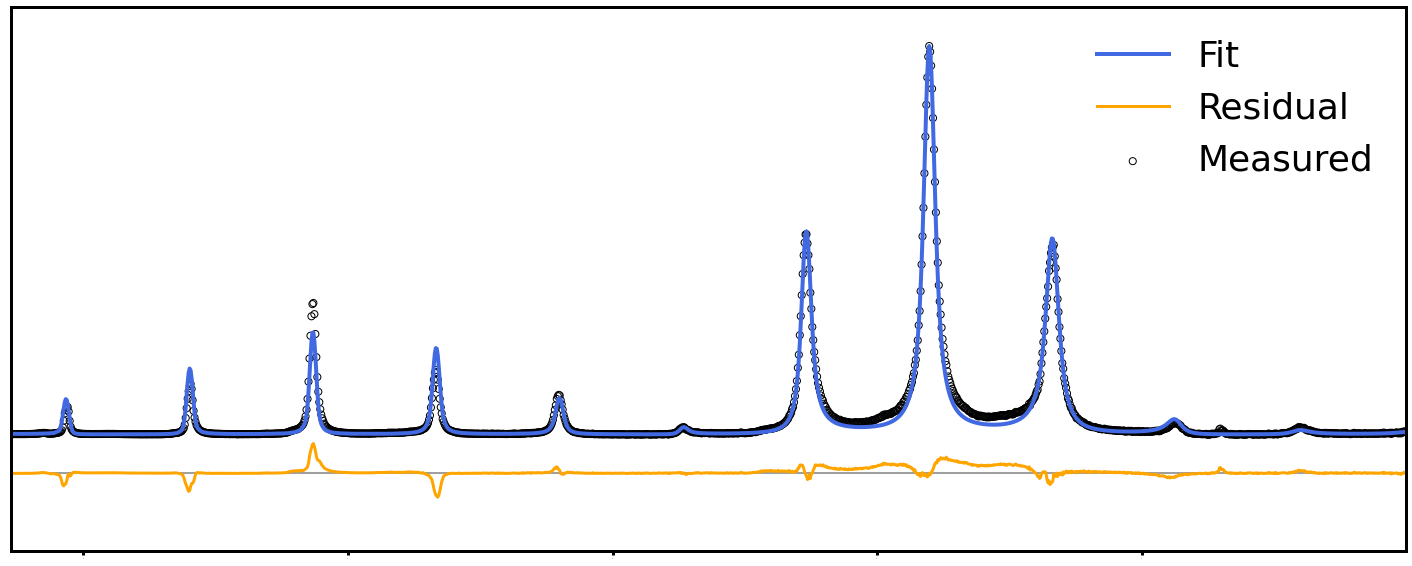

Fit Parameters: [  d         L    sigmaL    qzero   HWHM ]
Fit Parameters: [5.9039, 15.1626, 0.2413, -0.0020, 0.0034, 1.0237, 0.8624, 0.9645, -0.0598]

S:      0.028
Rp:     0.141
Rwp:    0.049


In [8]:
#                [   d       L     sigmaL    qzero   HWHM   C_dens     v1      v2      v3       v4  ]

up_bound =       [6.1000, 20.0000, 2.0000,  0.0100, 0.1000, 1.0238, 1.5000, 1.5000, 0.2000,   0.2000]
starting_guess = [5.9605, 15.2998, 0.2407, -0.0019, 0.0033, 1.0237, 0.5413, 0.9580, -0.0210,  0.0000]
low_bound =      [5.8000, 10.0000, 0.0000, -0.0100, 0.0000, 1.0237, 0.0000, 0.0000,-0.2000,  -0.2000]
experiment.add_var = 3

#_NO CHANGES BELOW THIS POINT__________________________________________________________________________________________________________________

experiment.starting_guess = starting_guess
starting_guess = starting_guess[:len(starting_guess)-(4-experiment.add_var)]
up_bound = up_bound[:len(up_bound)-(4-experiment.add_var)]
low_bound = low_bound[:len(low_bound)-(4-experiment.add_var)]

bounds = (low_bound, up_bound)
experiment.I_corr = experiment.correct(experiment.q_range,experiment.I_range)
fits = experiment.fit_high( x0 = starting_guess, bounds = bounds)

plt.rcParams["axes.linewidth"] = 3; fig,ax = plt.subplots(1,1,figsize = (25,10),sharey = True)
plt.axhline(y=-0.1, color='grey', linestyle='-')
ax.scatter(experiment.q_range,experiment.I_corr,facecolors = 'none', edgecolor = 'black',linewidth = 1,s = 50 ,label = 'Measured')
ax.plot(experiment.q_range,experiment.I_sim,label = 'Fit', color = 'royalblue', linewidth = 4)
ax.plot(experiment.q_range, experiment.I_corr - experiment.I_sim - 0.1 ,label = 'Residual', color = 'orange', linewidth = 3)
ax.legend(fontsize = 36, frameon = False); plt.ylim(-0.3, 1.1); ax.set_xlim(min(experiment.q_range),max(experiment.q_range))
ax.tick_params(axis = 'both', which = 'major', width = 3, labelsize = 0)
ax.set_yticks([]); plt.show(); plt.rcParams["axes.linewidth"] = 1

print('Fit Parameters: [  d         L    sigmaL    qzero   HWHM ]')
print (('Fit Parameters: ' + str(["{:.4f}".format(x) for x in experiment.x0])).replace('\'', '')); print()

S = np.sum(experiment.I_corr * (experiment.I_corr - experiment.I_sim)**2)
Rp = np.sum(abs(experiment.I_corr - experiment.I_sim))/np.sum(experiment.I_corr)
Rwp = (np.sum(experiment.I_corr*(experiment.I_corr - experiment.I_sim)**2)/(np.sum(experiment.I_corr**3)))**0.5

print ('S:      ' + str("{:.3f}".format(S)))
print ('Rp:     ' + str("{:.3f}".format(Rp)))
print ('Rwp:    ' + str("{:.3f}".format(Rwp)))

-----------------------------------------------------------------------------------------------------------
BOOTSTRAP ANALYSIS

This section repeats the fit n_random times (300 in this example) while adding to the experimental pattern a Gaussian noise of specified amplitude (assumed_error). The amplitude of the error was estimated by repeating the same measurement multiple times (see https://doi.org/10.1021/acsnano.0c08929 for details). 

The output provides the mean value and standard deviation of each fitted parameter. In addition to this, it is visualized a series of plots describing the mean value and standard deviation of each parameter (diagonal elements) as well as the cross-correlations between different parameters in the fit (off-diagonal elements). 

WARNING: this section is very time-consuming to run. It can take dozens of minutes or even hours: the program is not stuck, just wait a bit longer! A self-updating counter will show the number of iterations completed. To minimize the calculation time, set the best fit values just obtained as the "starting_guess" vector in the previous sector. The greater the difference between the "starting_guess" parameters and the best fit, the greater the duration of the calculation.

C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:115: RuntimeWarning: overflow encountered in power
  phi_prime = -np.sum(suf ** 2 / denom**3) / p_norm
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:154: RuntimeWarning: invalid value encountered in double_scalars
  ratio = phi / phi_prime
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:369: RuntimeWarning: invalid value encountered in greater_equal
  return np.all((x >= lb) & (x <= ub))
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:369: RuntimeWarning: invalid value encountered in less_equal
  return np.all((x >= lb) & (x <= ub))
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\common.py:398: RuntimeWarning: invalid value encountered in sign
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
C:\Users\tosos\anaconda3\lib\site-packages\scipy\optimize\_lsq\trf.py:363: RuntimeWarning: divide by zero encount

(300, 9)
d: 5.904 ± 0.0126
L: 15.1631 ± 0.0261
sigmaL: 0.2393 ± 0.0065
qzero: -0.002 ± 0.0006
HWHM: 0.0034 ± 0.0006
C_dens: 1.0237 ± 0.0
v1: 0.8675 ± 0.0355
v2: 0.9632 ± 0.026
v3: -0.0543 ± 0.0306


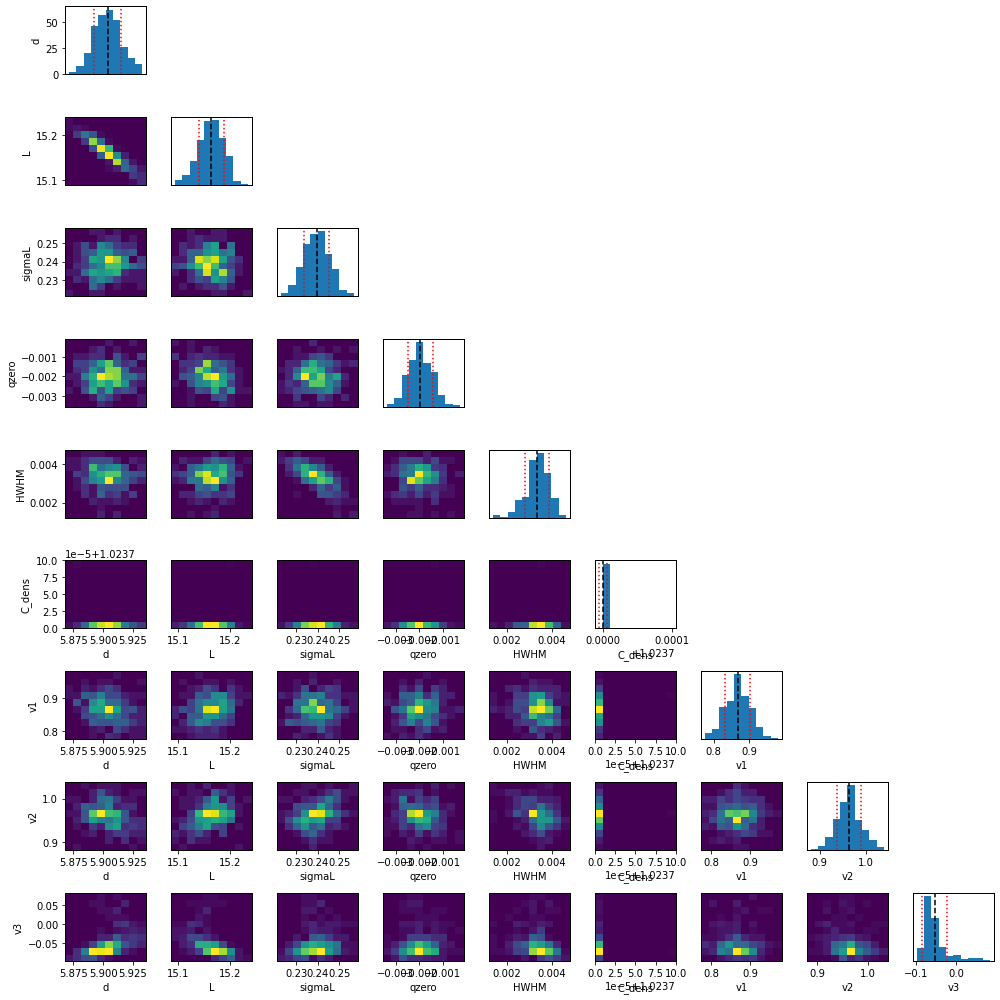

In [9]:
assumed_error = 0.03 # Insert an estimation of the experimental error on the intensities, e.g. 3%
n_random = 300

bs_results = experiment.fit_bootstrap(x0 = starting_guess,bounds = bounds,n_random=n_random, assumed_error=assumed_error)

bs_narray = np.array(bs_results)
param_values = bs_narray[:,0,:len(starting_guess)]
print(param_values.shape)
param_avgs = []
param_stds = []
fig,ax = plt.subplots(len(starting_guess),len(starting_guess),figsize = (14,14))
labels =  ['d','L','sigmaL','qzero','HWHM','C_dens','v1','v2','v3','v4']
for i in range(len(starting_guess)):
    for j in range(len(starting_guess)):
        if i==j:
            ax[i,j].hist(param_values[:,i])
            ax[i,j].axvline(np.average(param_values[:,i]),0,1,color='k',linestyle = '--')
            ax[i,j].axvline(np.average(param_values[:,i]) - np.std(param_values[:,i]),0,1,color='r',linestyle = ':')
            ax[i,j].axvline(np.average(param_values[:,i]) + np.std(param_values[:,i]),0,1,color='r',linestyle = ':')
            print(labels[i] + ': ' + str(round(np.average(param_values[:,i]),4)) + u" \u00B1 "  + str(round(np.std(param_values[:,i]),4)))
            param_avgs.append(np.average(param_values[:,i]))
            param_stds.append(np.std(param_values[:,i]))
        elif j<i:
            ax[i,j].hist2d(param_values[:,j],param_values[:,i])
        if i<5:
            ax[i,j].set_xticks([])
        else:
            ax[i,j].set_xlabel(labels[j])
        if j>0:
            ax[i,j].set_yticks([])
        else:
            ax[i,j].set_ylabel(labels[i])
        if j>i:
            fig.delaxes(ax[i,j])
            
fig.tight_layout()
plt.show()

-----------------------------------------------------------------------------------------------------------
BOOTSTRAP BEST FIT VISUALIZER

This section computes the diffraction pattern based on the best fit values found by the bootstrap analysis. We consider this plot and the corresponding paramenters to be the final output of the refinement procedure. 

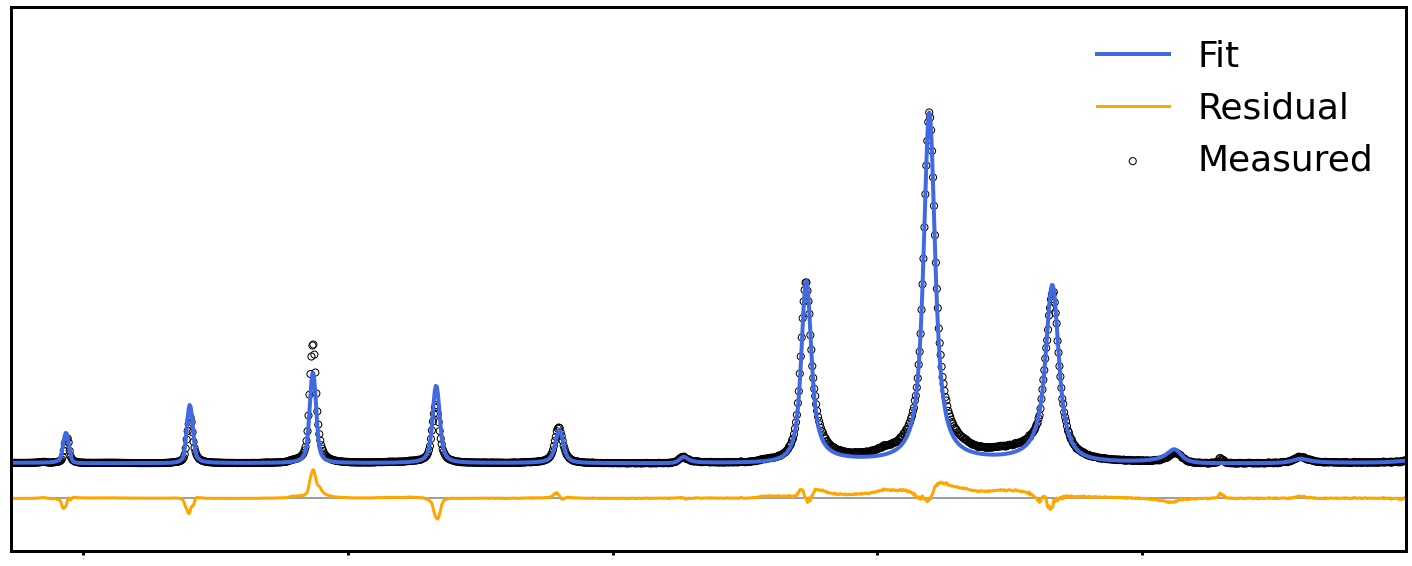

In [10]:
ref_param = starting_guess

for i in range(len(starting_guess)):
    for j in range(len(starting_guess)):
        if i==j:
            ref_param[i] = np.average(param_values[:,i])
            
experiment.simulate_high(ref_param)

plt.rcParams["axes.linewidth"] = 3

fig,ax = plt.subplots(1,1,figsize = (25,10),sharey = True)
plt.axhline(y=-0.1, color='grey', linestyle='-')
ax.scatter(experiment.q_range,experiment.I_corr,facecolors = 'none', edgecolor = 'black',linewidth = 1,s = 50 ,label = 'Measured')
ax.plot(experiment.q_range,experiment.I_sim,label = 'Fit', color = 'royalblue', linewidth = 4)
ax.plot(experiment.q_range, experiment.I_corr - experiment.I_sim - 0.1 ,label = 'Residual', color = 'orange', linewidth = 3)
ax.legend(fontsize = 36, frameon = False)
plt.ylim(-0.25, 1.3); ax.set_xlim(min(experiment.q_range),max(experiment.q_range))
ax.tick_params(axis = 'both', which = 'major', width = 3, labelsize = 0)
ax.set_yticks([]);plt.show()

plt.rcParams["axes.linewidth"] = 1

-----------------------------------------------------------------------------------------------------------
REFINED STRUCTURE VISUALIZATOR

This section let the user visualize the monodimensional representation of the nanoplatelet structure after the refinement, and shows the corresponding structure factor. 

,0,1,2,3,4
8,0,N,0.867525,Br-,0.867525
7,0.445673,,0,Br-,1
6,0.5,Pb2+,1,,0
5,0.554327,,0,Br-,1
4,1,Cs+,0.963231,Br-,0.963231
3,1.44567,,0,Br-,1
2,1.5,Pb2+,1,,0
1,1.55433,,0,Br-,1
0,2,N,0.867525,Br-,0.867525


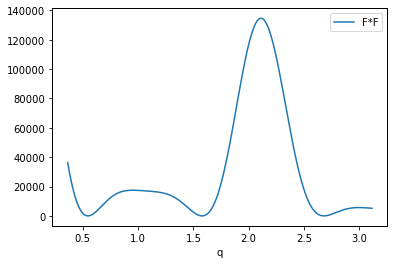

In [11]:
#_NO CHANGES BELOW THIS POINT__________________________________________________________________________________________________________________

v  = experiment.starting_guess[6:10] 
for i in range(6,len(ref_param)):
    v[i-6] = ref_param[i]

structure_output = experiment.relations(experiment.structure_input,v[0],v[1],v[2],v[3])     
representation = experiment.crystal_generator(structure_output)
representation = representation.T.iloc[::-1]
representation.rename(columns ={0: "z-coordinate"})
display(representation)
experiment.FF_simulator(experiment.x0[0])
experiment.F.plot("q","F*F")